In this Notebook I will try to study the frequencies of values for the encodings in the different positions. This study is aimed to understand what is a sensible level of noise to put to these encdoings values if one wants to do so. Ideally we want to put random Gaussian noise with a standard deviation roughly equal to $5\%$ or $10\%$ of the means of the deviations for the training set. Maybe then do one that depends on the position also? Actually we cannot since different proteins encodings have different lenghts.

In [39]:
from encoded_protein_dataset import EncodedProteinDataset, collate_fn, get_embedding
from pseudolikelihood import get_npll
import torch
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, RandomSampler
from potts_decoder import PottsDecoder
from functools import partial
from tqdm import tqdm



In [2]:
train_dataset = EncodedProteinDataset('/Data/InverseFoldingData/msas/train', '/Data/InverseFoldingData/structure_encodings')

In [8]:
train_dataset[0][1].shape

torch.Size([133, 512])

In [10]:
torch.std(train_dataset[0][1], axis=1).shape

torch.Size([133])

In [15]:
stds = torch.zeros(len(train_dataset))
iterator=0
for input in train_dataset:
    stds[iterator] = torch.mean(torch.std(input[1], axis=1))
    iterator+=1

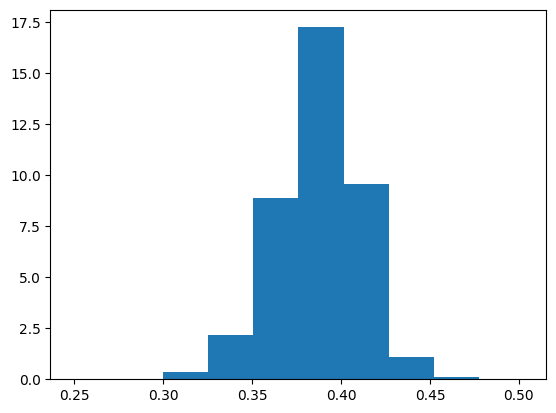

In [19]:
plt.hist(stds, density=True);

Seems that the deviation for different elements in the training dataset is not significant, and thus selecting a single value is a reasonable thing to do. Is this also sensible across the different dimensions of the encoding dimension?

In [21]:
stds2 = torch.zeros(len(train_dataset), 512)
iterator=0
for input in train_dataset:
    stds2[iterator, ::] = torch.std(input[1], axis=0)
    iterator+=1
stds2 = torch.mean(stds2, axis=0)

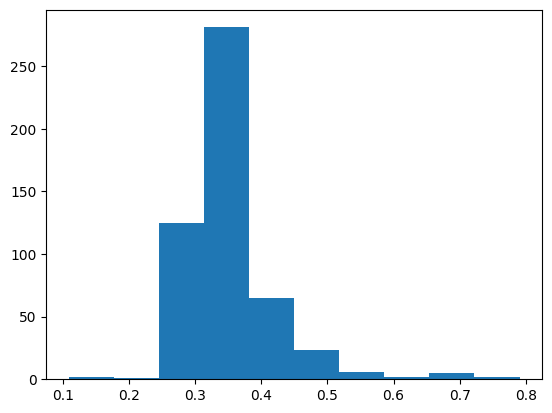

In [23]:
plt.hist(stds2);

Here seems a little more problematic, but I do not think it is worthy of a different approach for different positions in the encoding vector

I will now try the next idea, but I am not sure is completly sensible. I will train the model for a single epoch and use the weights found there. Infact since the the _projection_ layer is initialized to $0$, I don't think we can use the Potts Decoder out of the box. 

In [37]:
batch_structure_size = 4   ### I think with empty GPU we can hgo up to 10
perc_subset_test = 0.1     ## During the training, for every dataset available we select a random 10% of its samples
batch_msa_size = 16
q = 21 ##isn't always 21
collate_fn = partial(collate_fn, q=q, batch_msa_size=batch_msa_size)
train_loader = DataLoader(train_dataset, batch_size=batch_structure_size, collate_fn=collate_fn, shuffle=True)

In [43]:
decoder = None
embedding = None
torch.cuda.empty_cache()

seed = 0
torch.random.manual_seed(seed)
np.random.seed(seed)


input_encoding_dim = train_dataset.encoding_dim
param_embed_dim = 512
n_param_heads = 4
d_model = 128
n_heads = 2
n_layers = 2
## Check before running which is the GPU which is free the most and put it as the running device
device = 2
eta = 1e-3
dropout = 0,0

decoder = PottsDecoder(q, n_layers, d_model, input_encoding_dim, param_embed_dim, n_heads, n_param_heads)
decoder.to(device)
embedding = get_embedding(q)
embedding.to(device)

optimizer = torch.optim.Adam(decoder.parameters(), lr=0.0001)

def get_loss(decoder, inputs, eta):
    """eta is the multiplicative term in front of the penalized negative pseudo-log-likelihood"""
    msas, encodings, padding_mask  = [input.to(device) for input in inputs]
    B, M, N = msas.shape
    print(f"device:{device}")
    couplings, fields = decoder(encodings, padding_mask)

    # embed and reshape to (B, M, N*q)
    msas_embedded = embedding(msas.type(torch.int)).view(B, M, -1)

    # get npll
    npll = get_npll(msas_embedded, couplings, fields, N, q)


    padding_mask_inv = (~padding_mask)

    # multiply with the padding mask to filter non-existing residues (this is probably not necessary)       
    npll = npll * padding_mask_inv.unsqueeze(1)
    penalty = eta*(torch.sum(couplings**2) + torch.sum(fields**2))

    # the padding mask does not contain the msa dimension so we need to multiply by M
    npll_mean = torch.sum(npll) / (M * torch.sum(padding_mask_inv))

    return npll_mean + penalty ##we can just add the penalty since we have set already to 0 couplings and fields of padded elements


iterator=1
update_steps = 100
decoder.train()
with tqdm(total = update_steps) as pbar:
    update_step = 0
    for inputs in train_loader:
        update_step+=1
        #print(f"We are at: {iterator*batch_structure_size/len(train_dataset)}%", end="\r")
        train_batch_loss = get_loss(decoder, inputs, eta)    ## get the current loss for the batch
        optimizer.zero_grad()                           ## set previous dragients to 0
        train_batch_loss.backward()                     ## Get gradients
        optimizer.step()                                ## Do a step of GD
        iterator+=1
        ## Here we append the lossess in the different batches within the same epoch
        pbar.set_description(f'update_step: {update_step}')#, GPU total memory: {check_gpu_mem().values[device, 0]}, GPU used: {check_gpu_mem().values[device, 1]}')
        pbar.update(1)
        if update_step >= update_steps:
            break

update_step: 100: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


In [48]:
#1/0

ZeroDivisionError: division by zero

In [45]:
#import gc
#decoder = None
#embedding = None
#gc.collect()
#torch.cuda.empty_cache()

In [58]:
def get_loss(decoder, inputs, eta):
    """eta is the multiplicative term in front of the penalized negative pseudo-log-likelihood"""
    msas, encodings, padding_mask  = [input.to(device) for input in inputs]
    B, M, N = msas.shape
    #print(f"device:{device}")
    couplings, fields = decoder(encodings, padding_mask)

    # embed and reshape to (B, M, N*q)
    msas_embedded = embedding(msas.type(torch.int)).view(B, M, -1)

    # get npll
    npll = get_npll(msas_embedded, couplings, fields, N, q)


    padding_mask_inv = (~padding_mask)

    # multiply with the padding mask to filter non-existing residues (this is probably not necessary)       
    npll = npll * padding_mask_inv.unsqueeze(1)
    penalty = eta*(torch.sum(couplings**2) + torch.sum(fields**2))

    # the padding mask does not contain the msa dimension so we need to multiply by M
    npll_mean = torch.sum(npll) / (M * torch.sum(padding_mask_inv))

    return npll_mean + penalty

In [59]:
collate_fn = partial(collate_fn, q=q, batch_msa_size=batch_msa_size)
train_loader = DataLoader(train_dataset, batch_size=1, collate_fn=collate_fn, shuffle=True)
nppl = torch.zeros(len(train_dataset))
idx=0
device='cpu'
decoder.to(device)
decoder.eval()
embedding.to(device)


for input in train_loader:
    print(f"I am at index:{idx}", end="\r")
    nppl[idx] = get_loss(decoder, input, eta) 
    idx+=1

KeyboardInterrupt: 

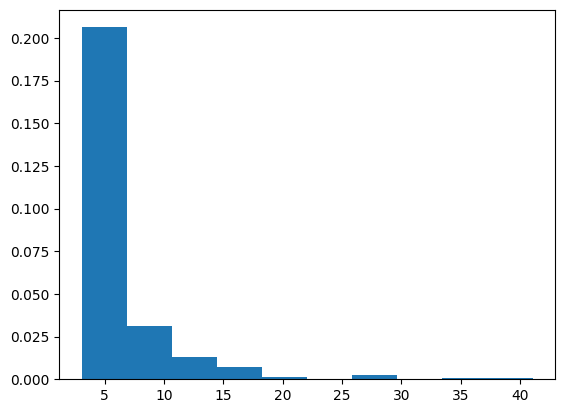

In [63]:
nppl = nppl[0:idx].detach().numpy()
plt.hist(nppl, density=True);

I am NOT convinced about this methodology with the model not-trained, I do not see why increasing the noise in the input should make the loss worse.